In [ ]:
import keras
import tensorflow as tf
from player_zero_builder import build_model

In [ ]:
model = build_model(scale=1)
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=48,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
model.save("./player_zero_model_gen0/")

In [ ]:
next_model = build_model(scale=2)

next_model.save("./player_zero_model_gen0_next/")


2024-05-09 23:23:52.610530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,144,78]
	 [[{{node inputs}}]]
2024-05-09 23:23:52.613682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,144,78]
	 [[{{node Placeholder}}]]


Allocating data for 1 data bundles.


2024-05-09 23:23:54.519019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 3s 3s/step
value pred: [0.94953436]
value true: [1.]
policy pred type: float32
policy truth type: float32
policy loss: tf.Tensor(0.11395815, shape=(), dtype=float32)
sum 1.0 min 0.0 max 0.9522181749343872
11 2 13 0.01879518
0 7 21 0.9522182
11 2 21 0.02898663


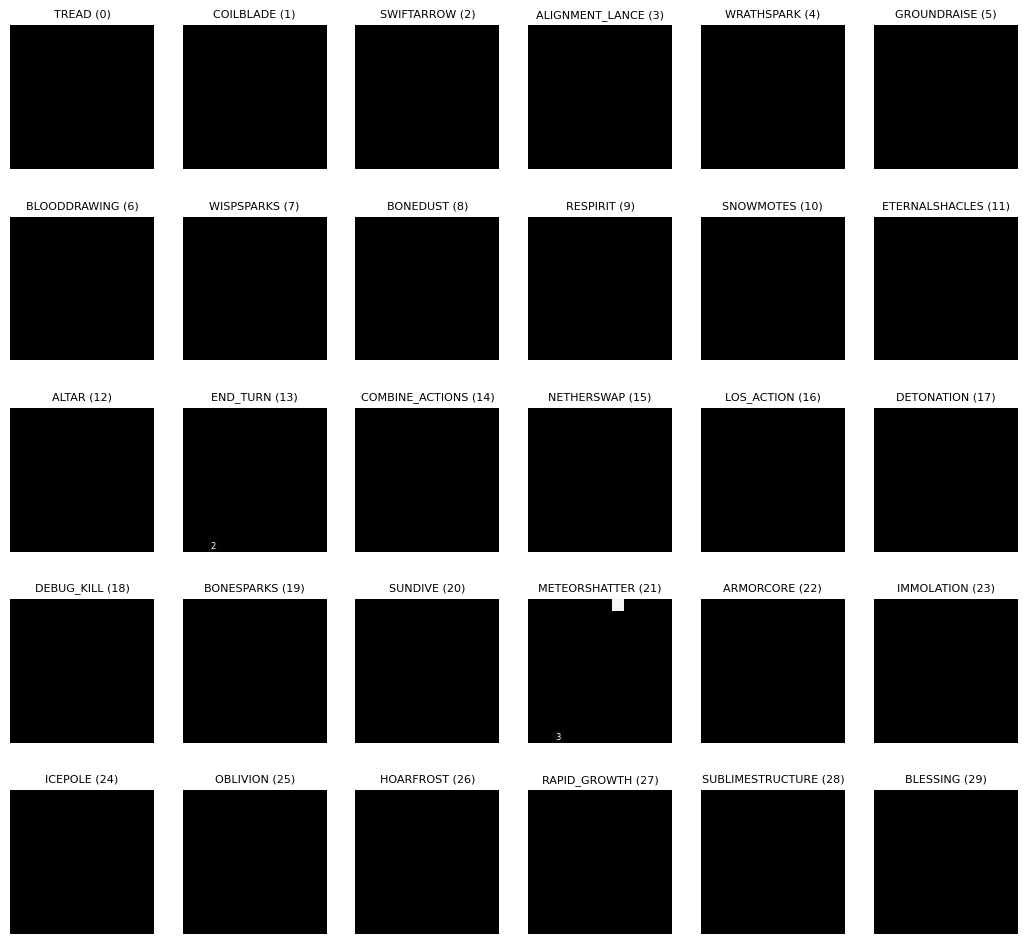

In [28]:
import player_zero_data as pzdata
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("latest_test_model")

data = []
pzdata.load_single_datapoint(data, filepath='gamedata.txt', use_random_samples=False)
board, mask, _, policy, value = pzdata.convert_data_to_numpy(data, use_random_flip=True)

# index = len(board) - 2
index = 0

board_stack = np.vstack([board[index]])
mask_stack = np.vstack([mask[index]])
policy_stack = np.vstack([policy[index]], dtype=np.single)
value_stack = np.vstack([value[index]])

ones = np.ones(shape=(len(mask_stack), 12 * 12 * 30))

model_policies, model_values = model.predict([board_stack, mask_stack])

print('value pred:', model_values[0])
print('value true:', value_stack[0])

print("policy pred type:", model_policies[0].dtype)
print("policy truth type:", policy_stack[0].dtype)

# for truth, pred in zip(policy_stack[0], model_policies[0]):
#     if abs(truth - pred):
#         print(truth, pred)

loss = tf.losses.categorical_crossentropy(
    y_pred=model_policies[0], y_true=policy_stack[0]
)
print("policy loss:", loss)


def plot(data):
    matrix = np.array(data).reshape((12, 12, 30))
    fig, axs = plt.subplots(5, 6, figsize=(13, 12))

    print(f"sum {matrix.sum()} min {np.min(matrix)} max {np.max(matrix)}")
    slice_names = ["TREAD", "COILBLADE", "SWIFTARROW", "ALIGNMENT_LANCE", "WRATHSPARK", "GROUNDRAISE", "BLOODDRAWING",
                   "WISPSPARKS", "BONEDUST", "RESPIRIT", "SNOWMOTES", "ETERNALSHACLES", "ALTAR", "END_TURN",
                   "COMBINE_ACTIONS", "NETHERSWAP", "LOS_ACTION", "DETONATION", "DEBUG_KILL", "BONESPARKS", "SUNDIVE",
                   "METEORSHATTER", "ARMORCORE", "IMMOLATION", "ICEPOLE", "OBLIVION", "HOARFROST", "RAPID_GROWTH",
                   "SUBLIMESTRUCTURE", "BLESSING"]

    for i in range(5):
        for j in range(6):
            slice_index = i * 6 + j
            axs[i, j].imshow(matrix[:, :, slice_index], interpolation='nearest', cmap='gray', vmin=0, vmax=1)
            axs[i, j].set_title(slice_names[slice_index] + f" ({slice_index})", fontsize=8)
            axs[i, j].axis('off')

            for m in range(12):
                for n in range(12):
                    v = round(matrix[m, n, slice_index] * 100)
                    if v > 0:
                        print(m, n, slice_index, matrix[m, n, slice_index])
                        axs[i, j].text(n, m, str(v), ha='center', va='center', color='white', fontsize=6)

    plt.show()


plot(model_policies)

In [15]:
import player_zero_data as pzdata
import numpy as np

board, mask, policy, value = [], [], [], []
pzdata.legacy_load_single_datapoint(board_list=board, mask_list=mask, action_list=[], policy_list=policy,
                                    value_list=value,
                                    filepath='gamedata.txt', use_random_samples=False, use_random_flip=False)

index = 0

board_stack = np.vstack([board[index]])
mask_stack = np.vstack([mask[index]])
policy_stack = np.vstack([policy[index]], dtype=np.single)
value_stack = np.vstack([value[index]])

new_data = []
pzdata.load_single_datapoint(data_list=new_data, filepath='gamedata.txt', use_random_samples=False)
nbs, nms, _, nps, nvs = pzdata.convert_data_to_numpy(new_data, use_random_flip=False)

print(np.all(nbs == board_stack))
print(np.all(nms == mask_stack))
print(np.all(nps == policy_stack))
print(np.all(nvs == value_stack))

for x1, x2 in zip(nps[0], policy_stack[0]):
    print(x1, x2) if x1 != x2 else None

Allocating data for 1 data bundles.
True
True
False
True
0.014853857211308098 0.014853857
0.0019166267369429804 0.0019166267
0.9832295160517489 0.9832295


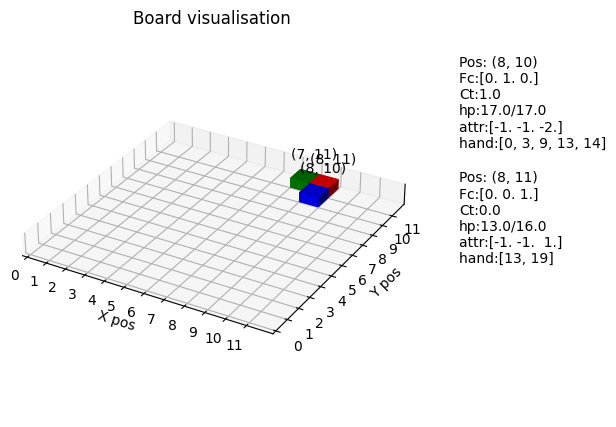

In [85]:
import matplotlib.pyplot as plt


def draw_board(data):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(111, projection='3d')
    plt.xlim(0, 12)
    plt.ylim(0, 12)

    ax2 = fig.add_subplot(122)
    plt.axis('off')

    data = data.reshape(12, 12, 18 + 30 * 2)

    # Plot bars for positions with non-zero attributes
    text_z = 1
    for x in range(12):
        for y in range(12):
            unit_data = data[x, y]
            if sum(unit_data) != 0:
                color = 'b' if unit_data[1] == 1 else 'r'

                hand = [k for (k, v) in enumerate(unit_data[18:48]) if v == 1.0]

                info = f"Pos: {x, y}\n" \
                       f"Fc:{unit_data[0:3]}\n" \
                       f"Ct:{unit_data[3]}\n" \
                       f"hp:{unit_data[4]}/{unit_data[5]}\n" \
                       f"attr:{unit_data[6:9]}\n" \
                       f"hand:{hand}"

                if unit_data[0] == 1:
                    color = 'g'
                    info = ''

                ax.bar3d(x, y, 0, dx=1, dy=1, dz=1, color=color)
                ax.text(x, y, 3, f"{x, y}", color='black')
                ax2.text(0.6, text_z, info, color='black')
                text_z -= 0.30

    ax.set_zlim(0, 2)
    # Set labels and title
    ax.set_xlabel('X pos')
    ax.set_ylabel('Y pos')
    ax.set_zlabel('')
    ax.set_zticks([])
    ax.set_yticks(range(12))
    ax.set_xticks(range(12))
    ax.set_box_aspect([1, 1, 1 / 12])
    ax.set_title('Board visualisation')

    plt.show()


draw_board(board_stack)


In [ ]:
import tensorflow as tf
import math

# tf.nn.softmax([-10000, 0, 5.0, -4.0])
"""
1 5 0 0.19602822
1 1 4 0.1607715
1 1 9 0.15043136
1 1 13 0.16176258
1 1 21 0.05731213
3 7 21 0.27369416
"""

tf.keras.losses.categorical_crossentropy(
    [0.2, 0.2, 0.1, 0.3],  # true
    [0.2, 0.2, 0.1, 0.3]  # pred
    #[0.172225, 0.185177, 0.00958768, 0.440238, 0.0737598, 0.119012]  # random inital
)


In [ ]:

from tensorflow.keras.layers import *
import numpy as np

mask_input = np.array([1.0, 0.0, 1.0])
px = np.array([2.0, 5.0, 5.0])

mx = Subtract()([np.full(mask_input.shape, 1.0), mask_input])
mx = Multiply()([mx, np.full(mask_input.shape, -1e9)])
px = Add()([px, mx])
px = Softmax()(px)

px


In [ ]:
import tensorflow as tf
import numpy as np

x = [
    -0.09,
    -0.564597,
    -0.564615,
    -0.56722,
    -0.565948,
    -0.566837,
    -0.566471,
    -0.567033,
    -0.566747,
]

inp = np.array(x)
inp *= 1
inp = tf.keras.layers.Softmax()(inp)
print(sum(inp), inp)

jnp = np.array(x)
sm = sum(x) + len(x)
jnp = (jnp + 1) / sm
print(sum(jnp), jnp)


def normalize_array(arr):
    # Shift the values to make them non-negative
    shifted_arr = [val + 1 for val in arr]

    # Calculate the sum of the shifted values
    sum_shifted = sum(shifted_arr)  # -1.0

    # Normalize each shifted value
    normalized_arr = [val / sum_shifted for val in shifted_arr]

    return normalized_arr


# Example usage
input_array = [-1.0, -1.0]
normalized_array = normalize_array(input_array)
print(normalized_array)
print(sum(normalized_array))



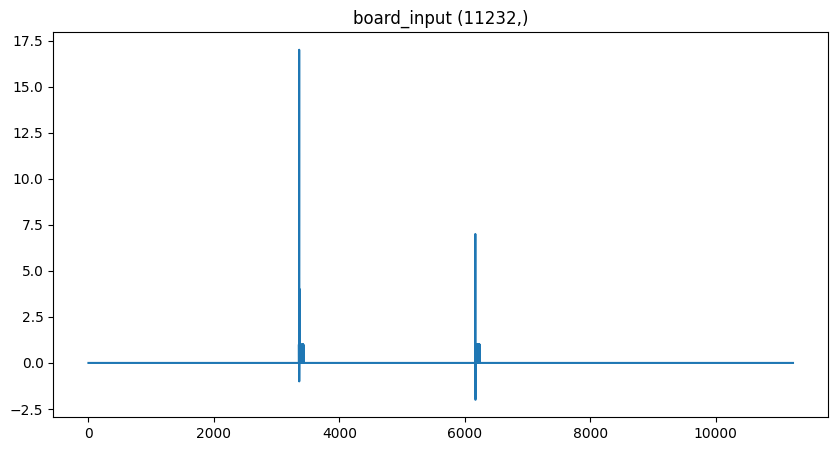

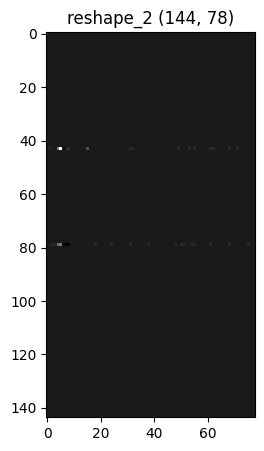

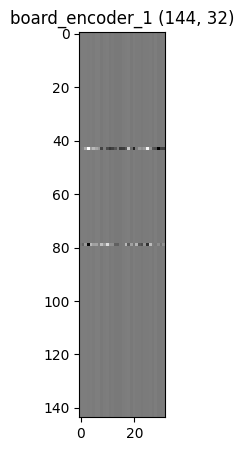

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

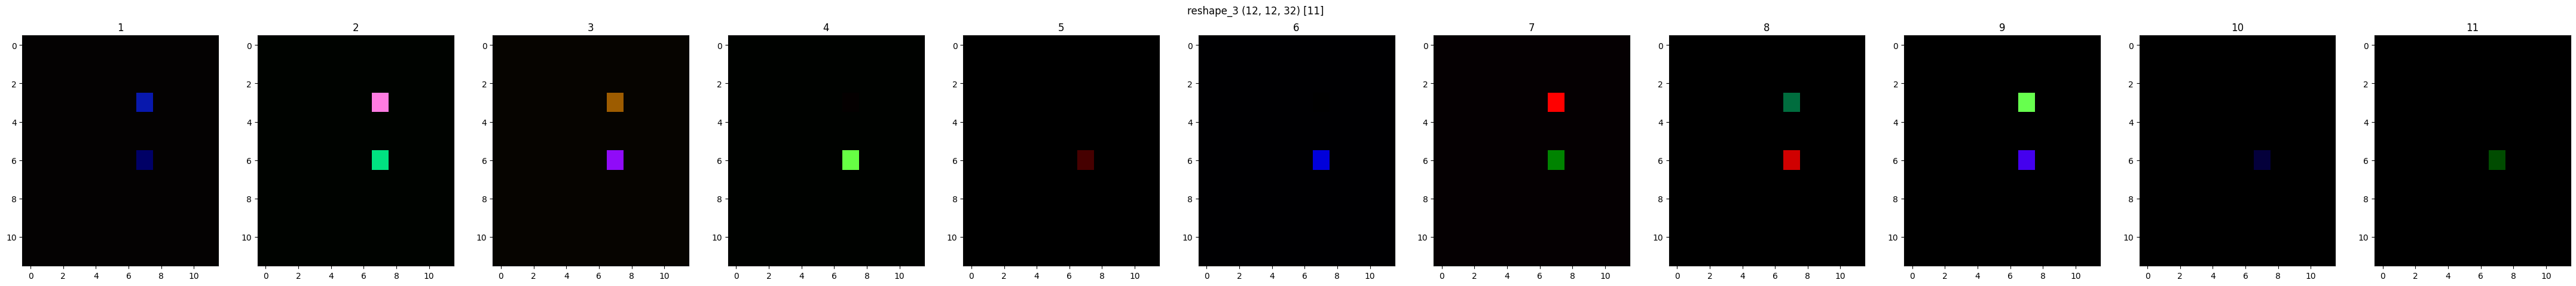

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

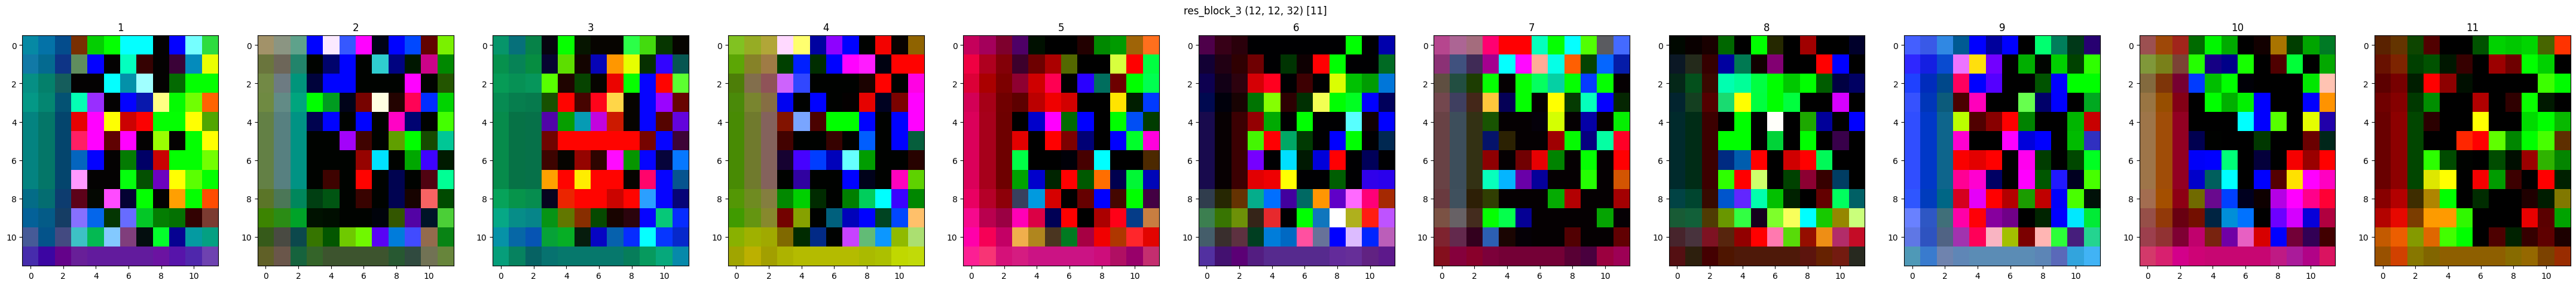

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

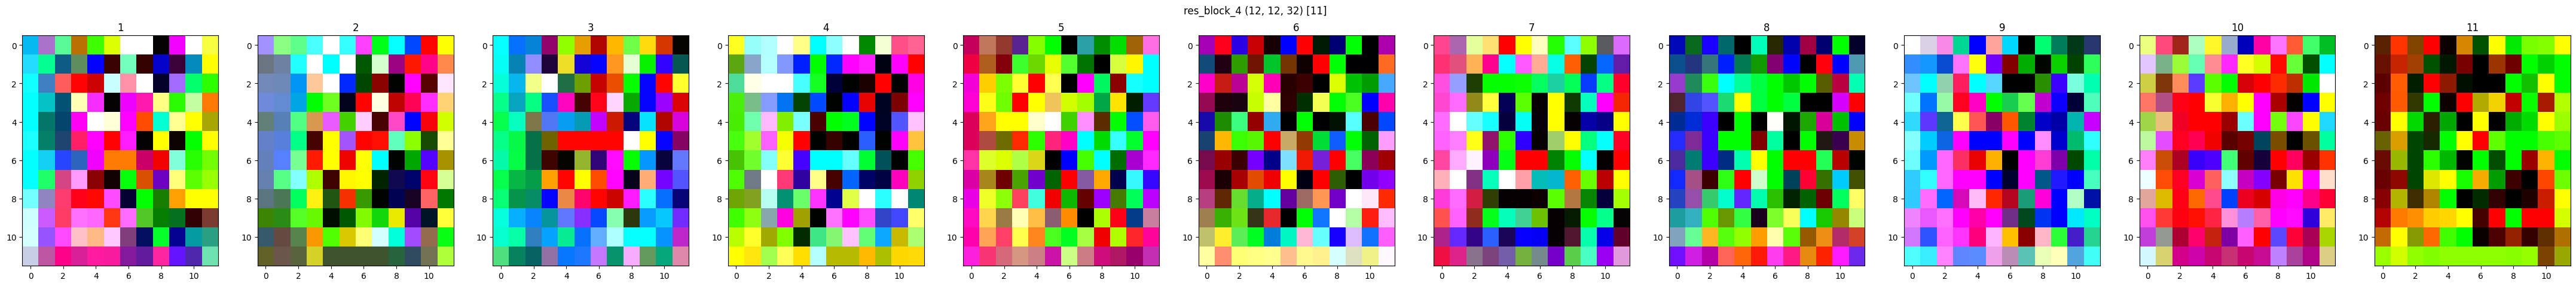

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

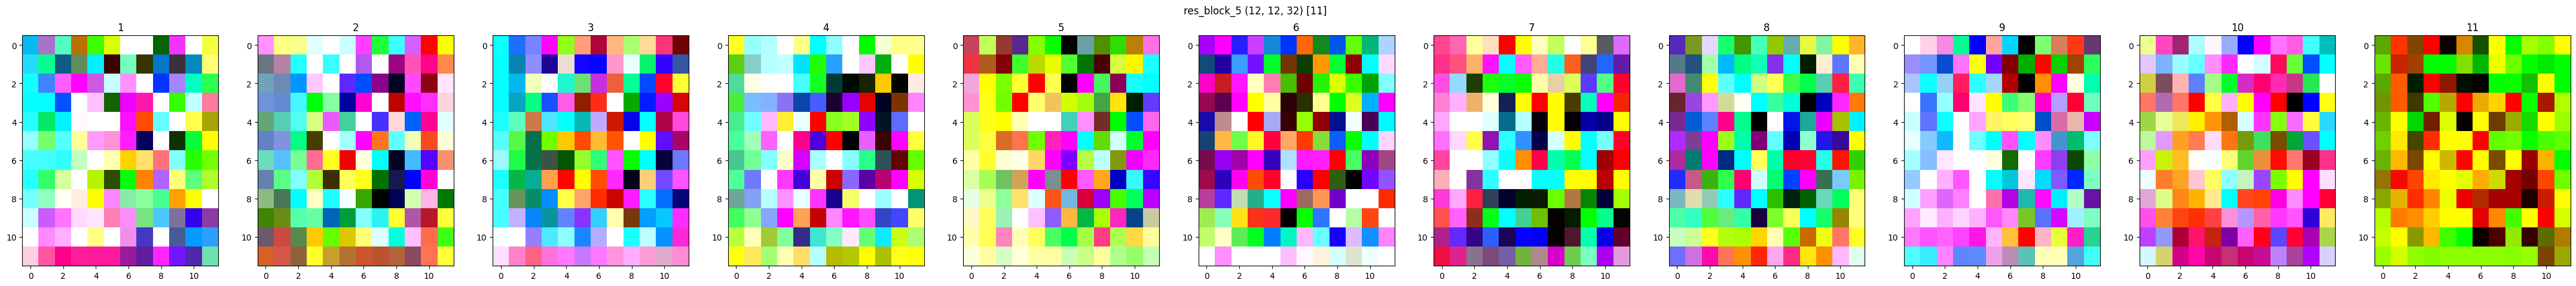

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

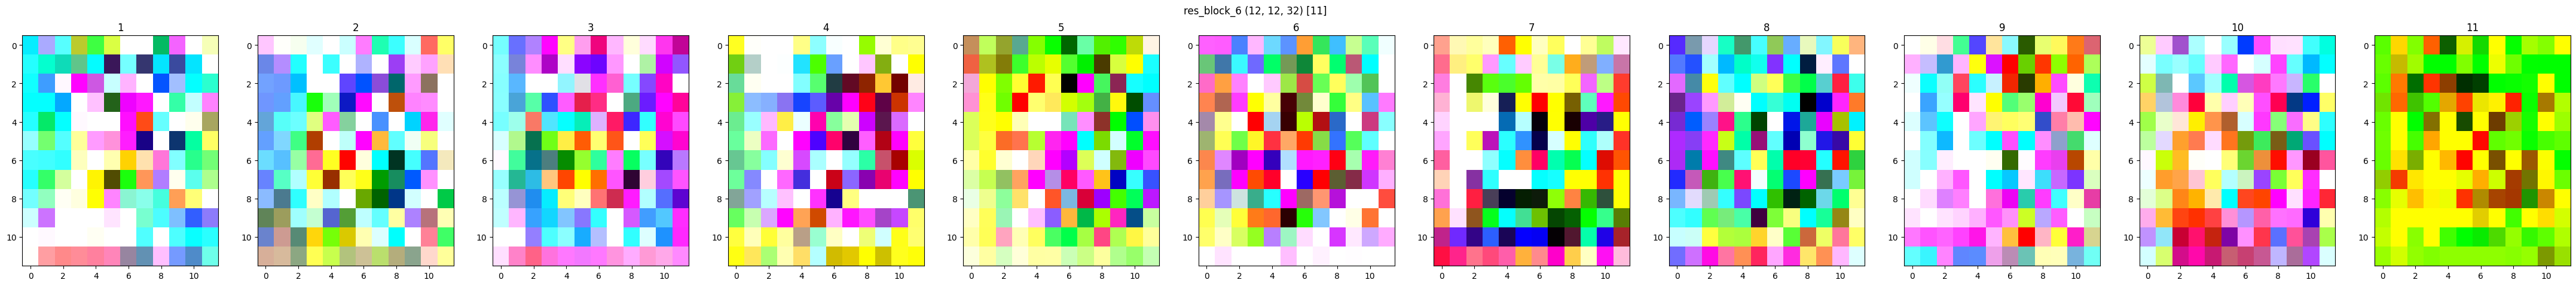

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

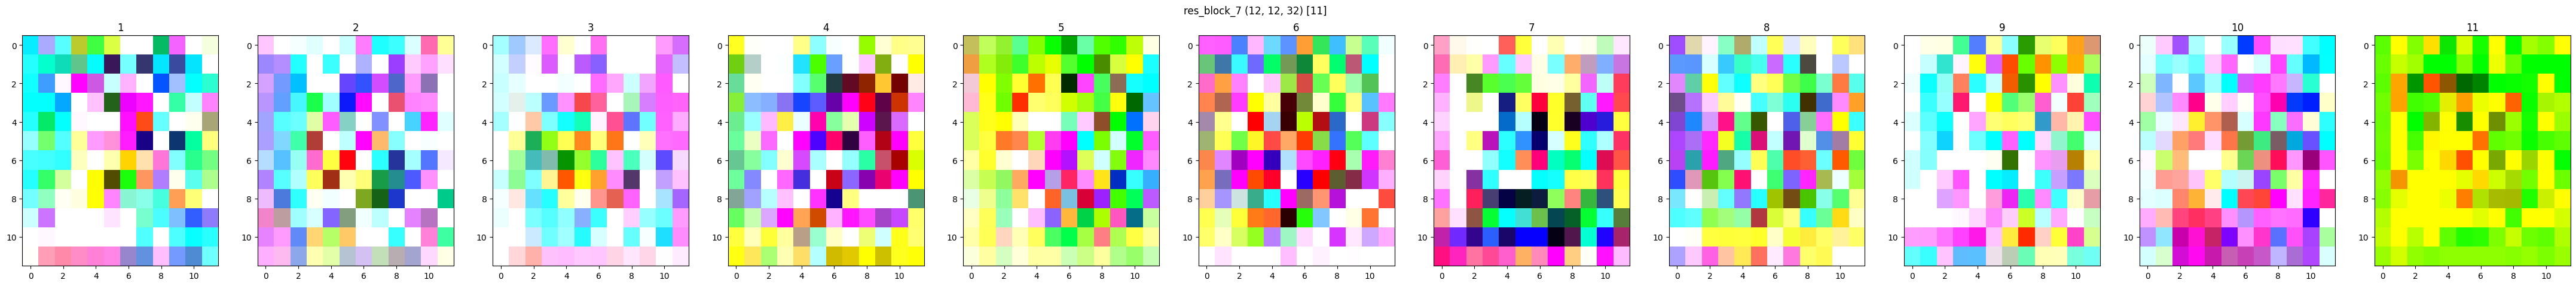

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


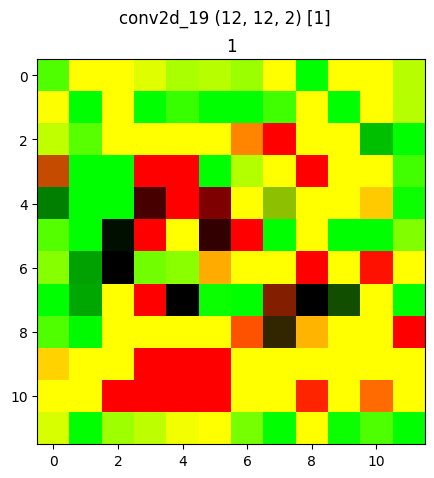

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


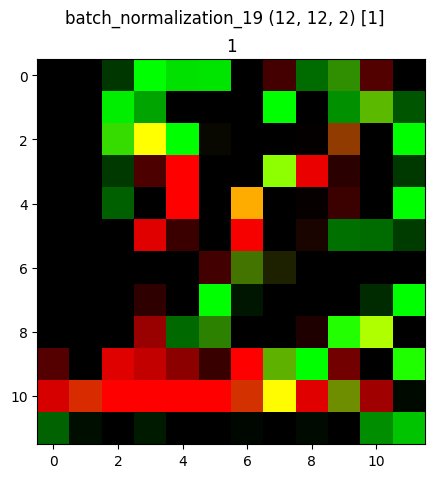

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

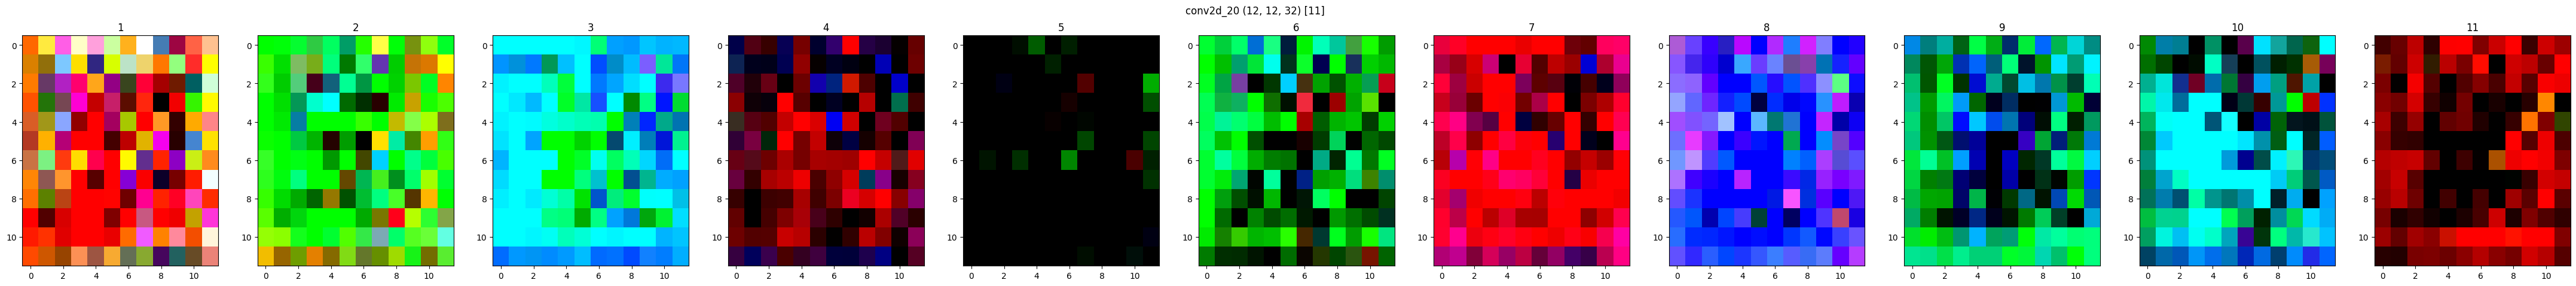

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


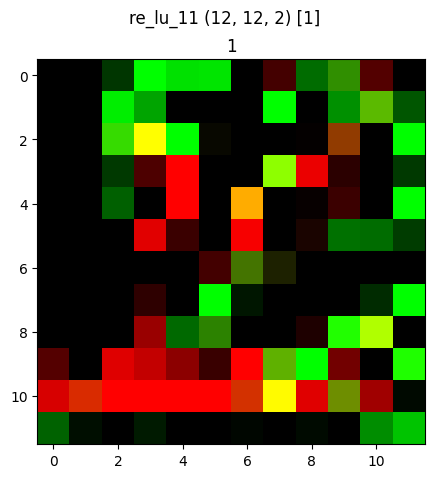

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

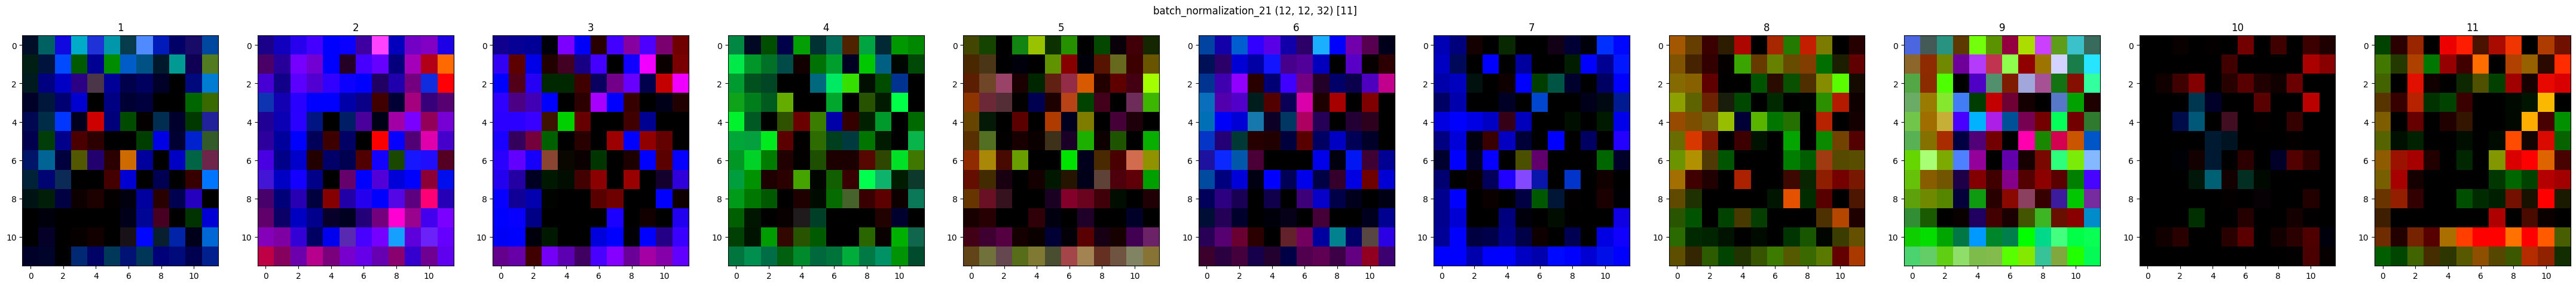

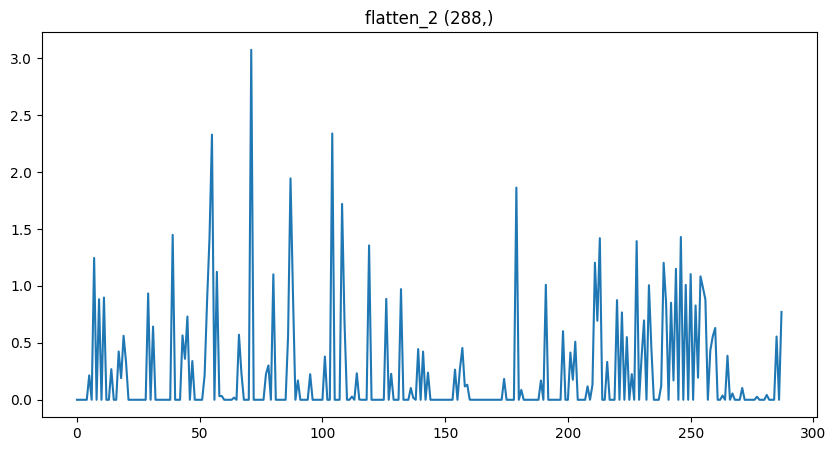

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


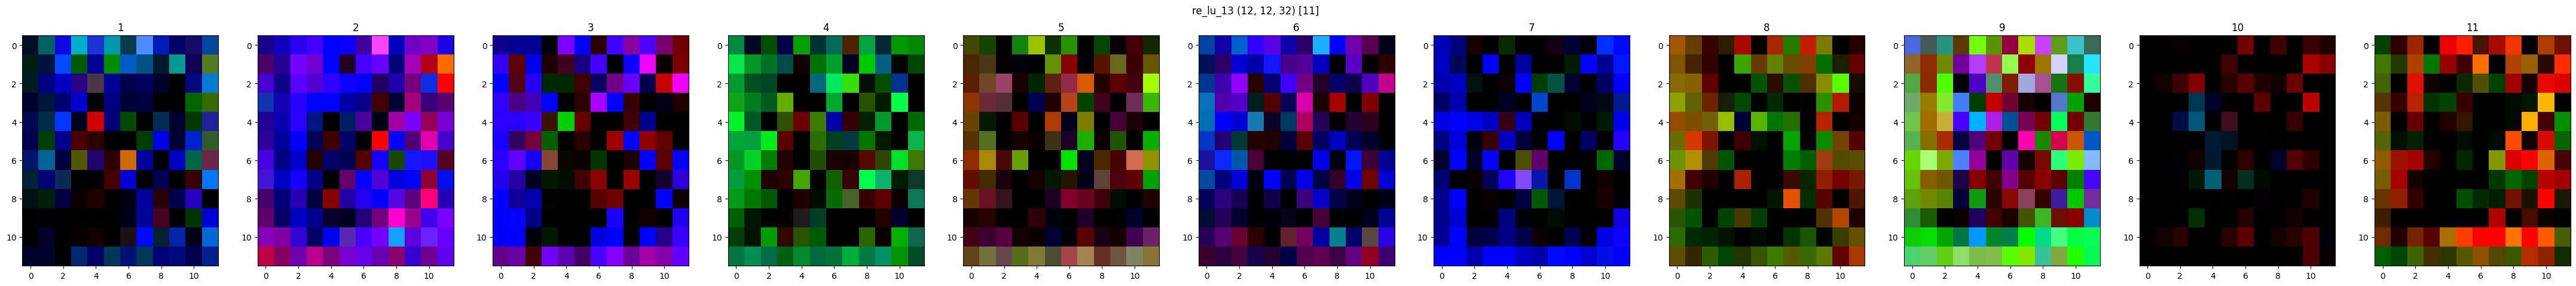

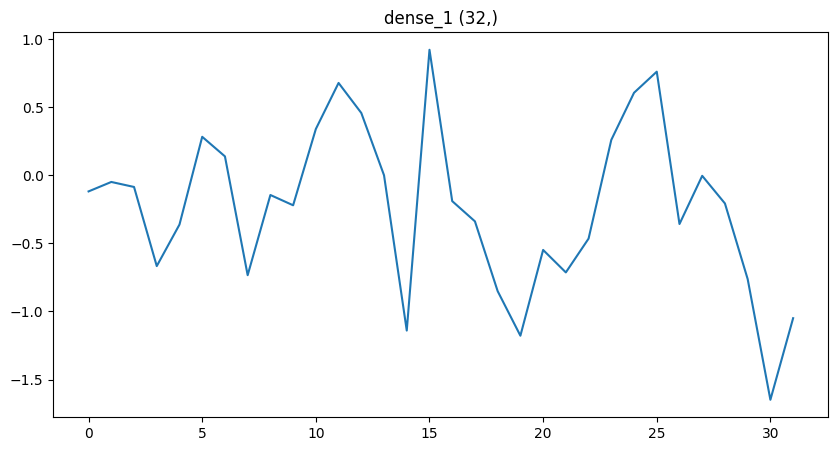

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

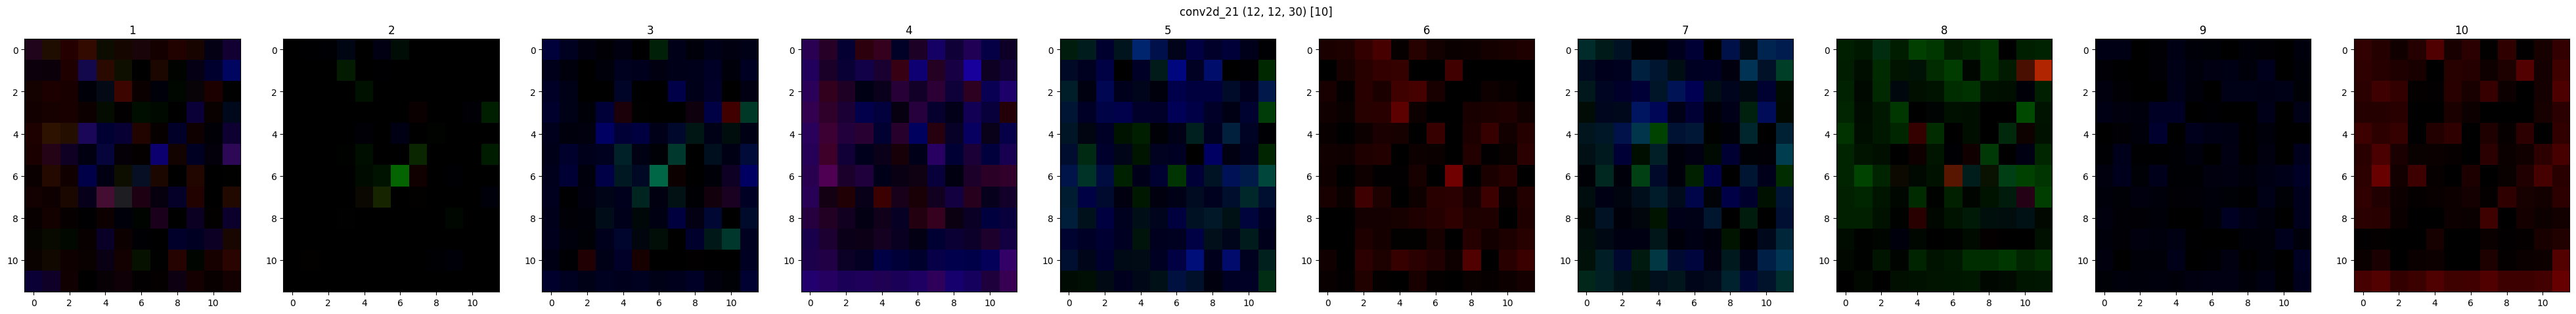

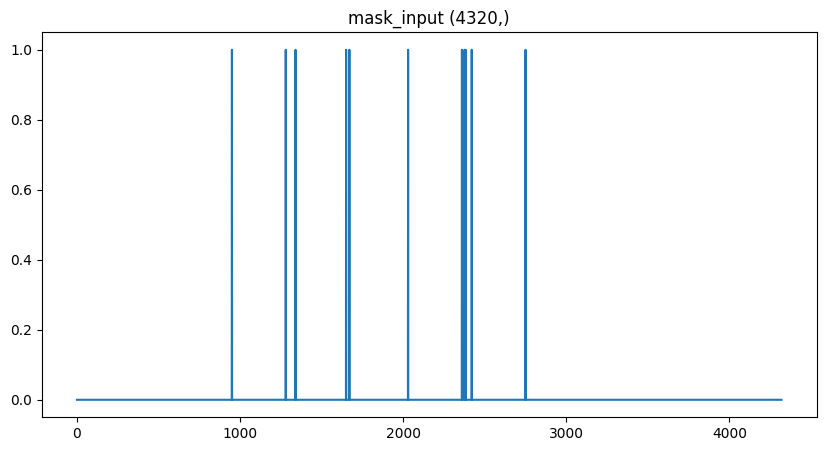

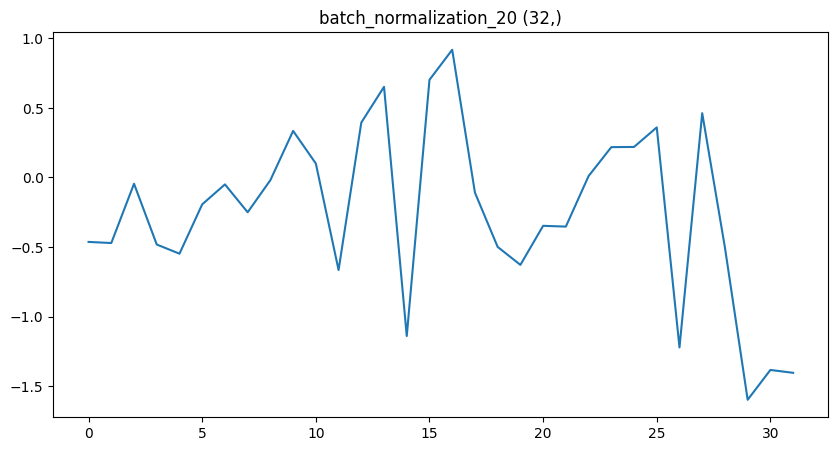

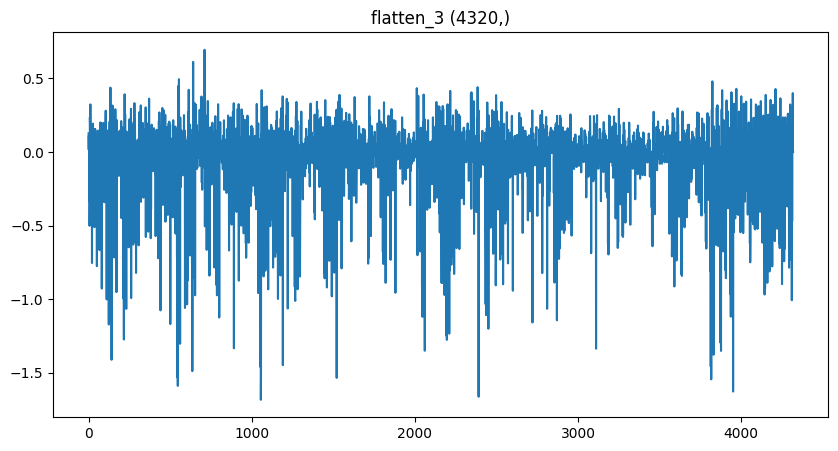

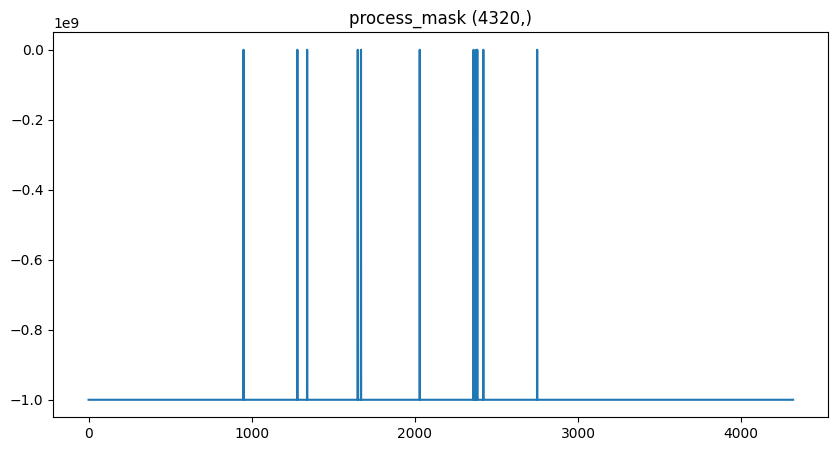

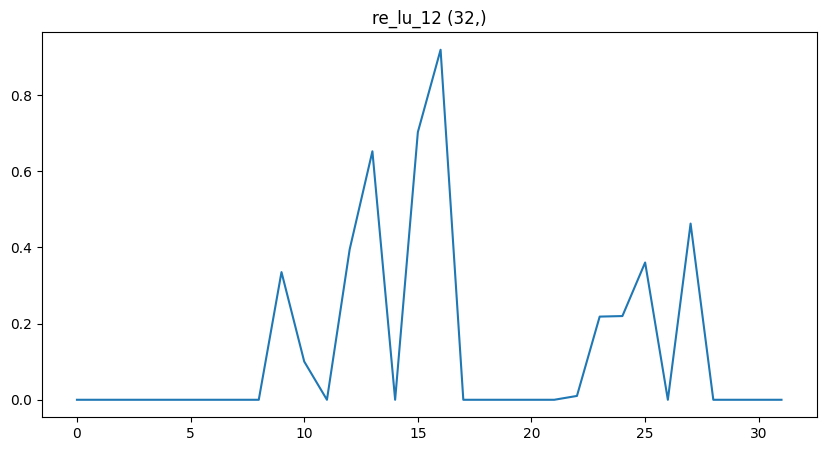

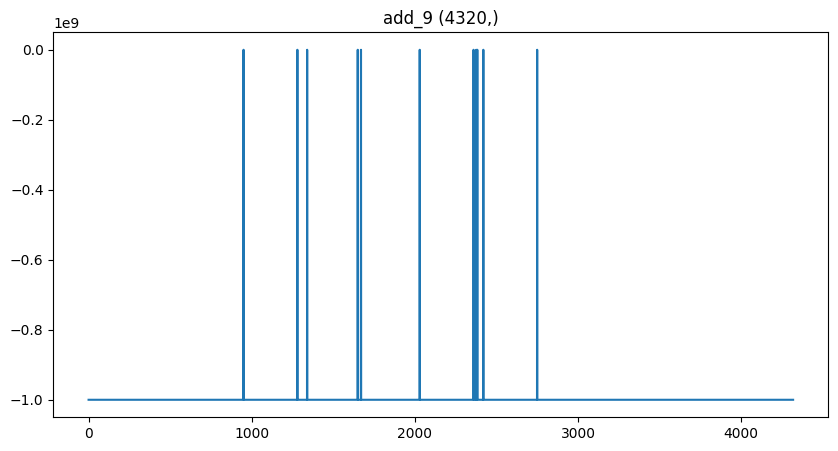

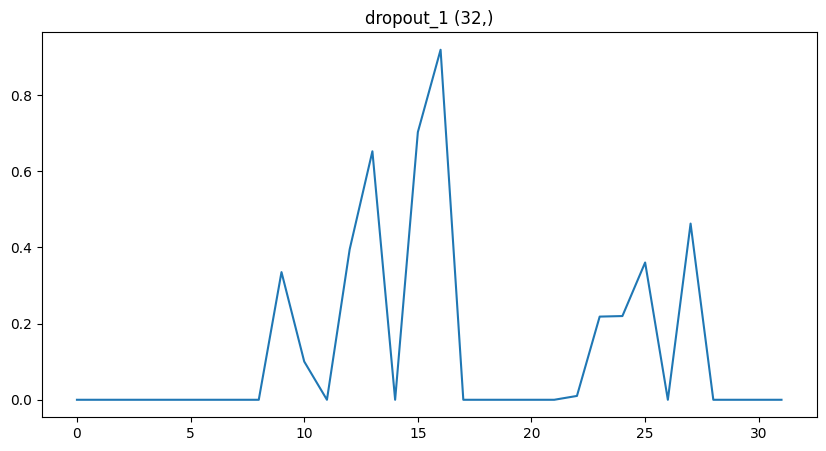

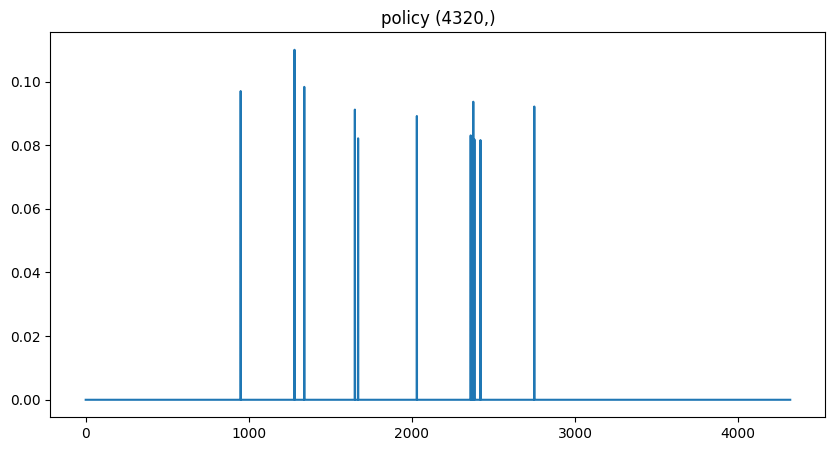

In [11]:
def get_activations(m: tf.keras.Model, input_tensor):
    activation_model = tf.keras.Model(inputs=m.input,
                                      outputs={layer.name: layer.output for layer in m.layers})
    return activation_model(input_tensor)


activations = get_activations(model, [board_stack, mask_stack])

for name, activation in activations.items():
    activation = tf.squeeze(activation)

    if activation.shape.rank == 0:
        continue
    elif activation.shape.rank == 1:
        plt.figure(figsize=(10, 5))
        plt.title(f'{name} {activation.shape}')
        plt.plot(activation)
        plt.show()
    elif activation.shape.rank == 2:
        plt.figure(figsize=(10, 5))
        plt.title(f'{name} {activation.shape}')
        plt.imshow(activation, interpolation='nearest', cmap='gray')
        plt.show()

    else:
        num_plots = activation.shape[-1] // 3 + (activation.shape[-1] % 3 != 0)

        plt.figure(figsize=(5 * num_plots, 5))
        plt.suptitle(f'{name} {activation.shape} [{num_plots}]')

        if (activation.shape[-1]) % 3 == 2:  # padding missing dims
            activation = np.pad(activation, ((0, 0), (0, 0), (0, 1)), mode='constant')

        for j in range(num_plots):
            start_idx = j * 3
            end_idx = min((j + 1) * 3, activation.shape[-1])
            plt.subplot(1, num_plots, j + 1)
            plt.imshow(activation[..., start_idx:end_idx], cmap='viridis', aspect='auto')
            plt.title(str(j + 1))
        plt.show()



In [2]:
import numpy as np

with open("../gaf6/board_fs.txt") as f:
    populated_board_raw = f.readline().rstrip(" ")

populated_board = np.array(list(map(int, populated_board_raw.split())))

import player_zero_data as pzdata

board, mask, policy, value = [], [], [], []
pzdata.load_single_datapoint(board_list=board, mask_list=mask, policy_list=policy, value_list=value,
                             filepath='../gaf6/node_fs.txt', use_random_samples=False)

node_board = board[0]

print(len(node_board))
print(len(populated_board))

print(all(node_board == populated_board))

for nb, pb in zip(node_board, populated_board):
    eq = nb == pb

    if not eq:
        print(nb, pb)


11232
11232
True


In [27]:

import  tensorflow as tf
import numpy as nop

x1 = np.array([2.4]).reshape(1, 1, 1)
x2 = np.array([5.0, 2.0, 3.0]).reshape(1, 3, 1)
tf.keras.layers.Multiply()([x1, x2])


<tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
array([[[12.       ],
        [ 4.8      ],
        [ 7.2000003]]], dtype=float32)>